---
title: "Análisis de proyección cambios componentes"
subtitle: "DANTOTSU"
author: "Departamento Confiabilidad"
date: today
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import dagster as dg

from kdags.definitions import *
from kdags.readr import *

context = dg.build_asset_context()
from kdags.assets.planning.component_changeouts.assets import *


dl = DataLake(context)
msgraph = MSGraph(context)
from kdags.assets.docs.io_catalog import *
from kdags.config.catalog_loader import DATA_CATALOG
from datetime import datetime
from theme_komatsu import *
from great_tables import GT, md
from component_constants import *
from datetime import timedelta

# Activos de datos

El siguiente reporte tiene como entrada los siguientes activos de datos estructurados:
- [**gfa_overhaul_rates**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/gfa_ovh_rates_df.xlsx): Tarifa GFA venta de componentes

- [**pcp_repair_costs**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/pcp_repair_costs.xlsx): Costos medios de reparación

- [**PAM Junio 2025**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/pam.xlsx)

Como datos no estructurados de inputs se utilizó adicionalmente:
- Datos manual de [**proyección de cambio de componentes faena**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/site_changeouts.xlsx)

- Datos mensuales de ingreso BP2025 por prorrata

In [9]:
component_df = MasterData.components()
equipments = MasterData.equipments()
positions_df = MasterData.positions()
pcp_repair_costs_df = dl.read_tibble(DATA_CATALOG["pcp_repair_costs"]["raw_path"])
gfa_ovh_rates_df = (
    dl.read_tibble(DATA_CATALOG["gfa_overhaul_rates"]["raw_path"])
    .select(
        [
            "site_name",
            "model_name",
            "component_name",
            "subcomponent_name",
            "mtbo",
            "gfa_overhaul_rate",
        ]
    )
    .drop_nulls("component_name")
).with_columns(gfa_overhaul_rate=pl.col("gfa_overhaul_rate").round(0).cast(pl.Int64))

cc_proj_df = pl.concat(
    [
        pl.DataFrame(component_data_raw_960E)
        .with_columns(model_name=pl.lit("960E"), site_name=pl.lit("MEL"))
        .with_columns(pl.col("month").str.to_date("%Y-%m-%d")),
        pl.DataFrame(component_data_raw_930E)
        .with_columns(model_name=pl.lit("930E-4"), site_name=pl.lit("MEL"))
        .with_columns(pl.col("month").str.to_date("%Y-%m-%d")),
        component_data_raw_spence.with_columns(
            model_name=pl.lit("980E-5"), site_name=pl.lit("SPENCE")
        ),
    ],
    how="diagonal_relaxed",
).rename({"month": "month_date"})


# Dejando lista la proyección componentes Haydee
cc_proj_df = (
    cc_proj_df.join(
        gfa_ovh_rates_df, how="left", on=["model_name", "site_name", "component_name"]
    )
    .join(
        pcp_repair_costs_df.join(
            component_df.select(
                ["subcomponent_tag", "component_name", "subcomponent_name"]
            ),
            how="left",
            on=["subcomponent_tag"],
        )
        .group_by(["site_name", "model_name", "component_name"])
        .agg(mean_repair_cost=pl.col("mean_repair_cost").sum()),
        how="left",
        on=["site_name", "model_name", "component_name"],
    )
    .with_columns(proj_component_hours=pl.col("mtbo") * 1.05)
    .pipe(calculate_prorrata_sale)
    .with_columns(
        site_sale=pl.col("prorrata_sale") * pl.col("cc_amount"),
        site_repair_cost=pl.col("mean_repair_cost") * pl.col("cc_amount"),
    )
)

# Procesamiento del PAM
file_content = dl.read_bytes("az://bhp-raw-data/PLANNING/PAM/PPTO_FY2025.xlsx")
pam_df = pd.read_excel(
    BytesIO(file_content), skiprows=5, sheet_name="PAM Gnral", usecols="A:AC", dtype=str
)

pam_df = (
    pl.from_pandas(pam_df)
    .select(
        [
            "Cod Comp RMCare",
            "Faena",
            "Modelo",
            "Cod Pos RMCare",
            "Fecha de Cambio",
            "Hrs Proy de cambio",
            "Costo",
            "Cantidad",
            "%USO",
            "NRO INT.",
            "Motivo de Cambio",
        ]
    )
    .rename(
        {
            "Cod Comp RMCare": "subcomponent_tag",
            "Cod Pos RMCare": "position_tag",
            "Hrs Proy de cambio": "proj_component_hours",
            "Fecha de Cambio": "proj_changeout_date",
            "Faena": "site_name",
            "Modelo": "model_name",
            "Costo": "pam_repair_cost",
            "Cantidad": "proj_cc_amount",
            "%USO": "component_usage",
            "NRO INT.": "pam_equipment_name",
            "Motivo de Cambio": "changeout_reason",
        }
    )
).with_columns(
    proj_changeout_date=pl.col("proj_changeout_date").str.to_date(
        "%Y-%m-%d %H:%M:%S", strict=False
    ),
    proj_component_hours=pl.col("proj_component_hours").cast(
        pl.Float64, strict=False
    ),  ##Revisar
    proj_cc_amount=pl.col("proj_cc_amount").cast(pl.Int64),
    pam_repair_cost=pl.col("pam_repair_cost").cast(pl.Float64),
    component_usage=pl.col("component_usage").cast(pl.Float64, strict=False).round(0),
    model_name=pl.col("model_name").replace(
        {
            "960E-1": "960E",
            "960E-2": "960E",
        }
    ),
    site_name=pl.col("site_name").replace(
        {
            "Spence": "SPENCE",
            "Escondida": "MEL",
        }
    ),
    changeout_reason=pl.col("changeout_reason").fill_null(pl.lit("unknown")),
)
pam_df = pam_df.filter(pl.col("model_name").is_in(["930E-4", "960E", "980E-5"]))
pam_df = pam_df.filter(pl.col("site_name").is_in(["SPENCE", "MEL"]))
pam_df = pam_df.join(
    component_df.select(["subcomponent_tag", "component_name", "subcomponent_name"]),
    on="subcomponent_tag",
    how="left",
).join(
    positions_df.select(["position_name", "position_tag"]),
    on="position_tag",
    how="left",
)

# Agregar costos medios PCP
pcp_merge_columns = ["site_name", "model_name", "subcomponent_tag"]
pam_df = (
    pam_df.join(
        pcp_repair_costs_df.select([*pcp_merge_columns, "mean_repair_cost", "tbo"]),
        on=pcp_merge_columns,
        how="left",
        validate="m:1",
    )
    .join(
        component_df.select(
            ["component_name", "subcomponent_name", "subcomponent_main"]
        ),
        how="left",
        on=["component_name", "subcomponent_name"],
    )
    .with_columns(
        proj_cc_amount=(pl.col("subcomponent_main") * 1).fill_null(0)
        * pl.col("proj_cc_amount")
    )
    .drop("subcomponent_main")
)


pam_df = pam_df.join(
    gfa_ovh_rates_df,
    how="left",
    on=["site_name", "model_name", "component_name", "subcomponent_name"],
).pipe(calculate_prorrata_sale)

2025-06-12 13:33:58 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/pcp_repair_costs.xlsx
2025-06-12 13:33:58 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/pcp_repair_costs.xlsx
2025-06-12 13:33:58 -0400 - dagster - INFO - system - Data shape: 45 rows, 11 columns
2025-06-12 13:33:58 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-12 13:33:59 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-12 13:33:59 -0400 - dagster - INFO - system - Data shape: 26 rows, 7 columns


In [81]:
# Subiendo archivos
hide = msgraph.upload_tibble(
    pcp_repair_costs_df, "sp://KCHCLGR00058/___/PAM/pcp_repair_costs_df.xlsx"
)
hide = msgraph.upload_tibble(
    gfa_ovh_rates_df, "sp://KCHCLGR00058/___/PAM/gfa_ovh_rates_df.xlsx"
)
hide = msgraph.upload_tibble(pam_df, "sp://KCHCLGR00058/___/PAM/pam.xlsx")
hide = msgraph.upload_tibble(
    cc_proj_df, "sp://KCHCLGR00058/___/PAM/site_changeouts.xlsx"
)

2025-06-12 11:46:07 -0400 - dagster - INFO - system - Writing 45 rows, 11 columns to sp://KCHCLGR00058/___/PAM/pcp_repair_costs_df.xlsx
2025-06-12 11:46:19 -0400 - dagster - INFO - system - Writing 26 rows, 6 columns to sp://KCHCLGR00058/___/PAM/gfa_ovh_rates_df.xlsx
2025-06-12 11:46:30 -0400 - dagster - INFO - system - Writing 933 rows, 19 columns to sp://KCHCLGR00058/___/PAM/pam.xlsx
2025-06-12 11:46:43 -0400 - dagster - INFO - system - Writing 163 rows, 13 columns to sp://KCHCLGR00058/___/PAM/site_changeouts.xlsx


## Análisis del PAM

## Diferencia entre costo proyectado PAM y costo medio

In [3]:
diff_df = pam_df.with_columns(
    delta_cost=(
        pl.col("pam_repair_cost") - (pl.col("mean_repair_cost") * pl.col("cc_amount"))
    ).round(0)
).filter(
    abs(pl.col("delta_cost")) >= 500
)  # .write_excel("diferencia_costos.xlsx")
msgraph.upload_tibble(diff_df, "sp://KCHCLGR00058/___/PAM/diferencia_costos_pam.xlsx")

GT(
    diff_df.group_by(["site_name", "component_name"]).agg(
        [
            pl.col("delta_cost").sum().alias("total_delta_cost"),
            pl.col("delta_cost").count().alias("record_count"),
        ]
    )
).tab_options(table_font_size="footnotesize", container_width="100%")

ColumnNotFoundError: cc_amount

* **Causa común**: Todas las filas traen `pam_repair_cost = 0`; el hueco proviene de costos aún no imputados en PAM, no de un benchmark incorrecto.
* Existe consistencia en el cálculo del PAM, el PAM muestra el costo medio de reparación


## Venta

In [10]:
# Then join back to your main aggregation
sale_df = (
    pam_df.group_by(
        [
            "site_name",
            "model_name",
            "component_name",
            "position_name",
            "pam_equipment_name",
            "proj_changeout_date",
            "proj_component_hours",
            "changeout_reason",
        ],
        maintain_order=True,
    )
    .agg(
        proj_cc_amount=pl.col("proj_cc_amount").sum(),
        pam_repair_cost=pl.col("pam_repair_cost").sum(),
        prorrata_sale=pl.col("prorrata_sale").sum(),
    )
    .with_columns(proj_cc_amount=pl.col("proj_cc_amount").cast(pl.Int64))
)


sale_df = sale_df.filter(pl.col("proj_changeout_date").is_not_null())


monthly_df = (
    (
        sale_df.with_columns(
            pl.date(
                pl.col("proj_changeout_date").dt.year(),
                pl.col("proj_changeout_date").dt.month(),
                1,
            ).alias("month_date")
        )
        .group_by(["site_name", "model_name", "component_name", "month_date"])
        .agg(
            pam_repair_cost=pl.col("pam_repair_cost").sum(),
            prorrata_sale=pl.col("prorrata_sale").sum(),
            proj_cc_amount=pl.col("proj_cc_amount").sum(),
        )
        .sort(["site_name", "month_date"])
    )
    .join(
        cc_proj_df.with_columns(cc_amount=pl.col("cc_amount").fill_null(0))
        .group_by(["site_name", "model_name", "component_name", "month_date"])
        .agg(
            site_repair_cost=pl.col("site_repair_cost").sum(),
            site_sale=pl.col("site_sale").sum(),
            cc_amount=pl.col("cc_amount").sum(),
        ),
        how="full",
        coalesce=True,
        on=["site_name", "model_name", "component_name", "month_date"],
    )
    .with_columns(
        site_repair_cost=pl.col("site_repair_cost").round(0).cast(pl.Int64),
        site_sale=pl.col("site_sale").round(0).cast(pl.Int64),
        pam_repair_cost=pl.col("pam_repair_cost").round(0).cast(pl.Int64),
        prorrata_sale=pl.col("prorrata_sale").round(0).cast(pl.Int64),
    )
)
model_monthly_df = (
    monthly_df.group_by(
        [
            "site_name",
            "model_name",
            "month_date",
        ]
    )
    .agg(
        pl.sum(
            "pam_repair_cost",
            "prorrata_sale",
            "proj_cc_amount",
            "site_repair_cost",
            "site_sale",
        )
    )
    .sort(
        [
            "site_name",
            "model_name",
            "month_date",
        ]
    )
)
site_monthly_df = (
    monthly_df.group_by(
        [
            "site_name",
            "month_date",
        ]
    )
    .agg(
        pl.sum(
            "pam_repair_cost",
            "prorrata_sale",
            "proj_cc_amount",
            "site_repair_cost",
            "site_sale",
            "cc_amount",
        )
    )
    .join(
        bp_df,
        how="left",
        on=["site_name", "month_date"],
    )
).sort(
    [
        "site_name",
        "month_date",
    ]
)
GT(site_monthly_df)

site_name,month_date,pam_repair_cost,prorrata_sale,proj_cc_amount,site_repair_cost,site_sale,cc_amount,bp_sale,bp_repair_cost
MEL,2025-04-01,253133,1365196,22,2711363,1950597,23,1427906,1354432
MEL,2025-05-01,571840,1238912,19,1177395,953597,15,1135285,1076833
MEL,2025-06-01,554821,1747933,21,2487754,2209163,20,1215772,1193359
MEL,2025-07-01,1024266,1579452,17,2471267,1999987,27,1176895,1158096
MEL,2025-08-01,1227598,2055159,21,1990517,1454475,19,998006,1107236
MEL,2025-09-01,1478677,1757591,20,1620533,1413250,18,998347,1085013
MEL,2025-10-01,1353281,1665015,18,1228071,1042658,13,643246,634031
MEL,2025-11-01,1434283,1697608,19,1183258,1004177,12,491517,459870
MEL,2025-12-01,1353321,1650020,18,1001933,768492,10,179980,176861
MEL,2026-01-01,1423761,1583037,16,1370581,689553,15,468983,399166


### Cargando resultados proyecciones

In [84]:
def create_pivot_table(monthly_df, model_name, value_name):
    """
    Create a pivot table for a specific model with components as rows and months as columns.

    Args:
        monthly_df (pl.DataFrame): Source dataframe with columns: model_name, component_name, month_date, cc_amount
        model_name (str): The model name to filter for

    Returns:
        pl.DataFrame: Pivot table with component_name as index and month dates as columns
    """
    # Filter for the specified model and create pivot table
    pivot_df = monthly_df.filter(pl.col("model_name") == model_name).pivot(
        values=value_name,
        index="component_name",
        columns="month_date",
        aggregate_function="sum",  # In case there are duplicates
    )

    # Sort columns by date
    date_columns = [col for col in pivot_df.columns if col != "component_name"]
    date_columns.sort()

    # Reorder columns
    pivot_df = pivot_df.select(["component_name"] + date_columns)

    # Optional: Format column names to match YYYY-MM-DD format
    pivot_df = pivot_df.rename(
        {
            col: col.strftime("%Y-%m-%d") if hasattr(col, "strftime") else str(col)
            for col in pivot_df.columns
            if col != "component_name"
        }
    )

    return pivot_df


cc_980E_df = create_pivot_table(monthly_df, "980E-5", "cc_amount")
r = msgraph.upload_tibble(
    cc_980E_df,
    "sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_980E_faena.xlsx",
)
pam_cc_980E_df = create_pivot_table(monthly_df, "980E-5", "proj_cc_amount")
r = msgraph.upload_tibble(
    pam_cc_980E_df,
    "sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_980E_soporte.xlsx",
)
cc_930E_df = create_pivot_table(monthly_df, "930E-4", "cc_amount")
r = msgraph.upload_tibble(
    cc_930E_df,
    "sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_930E_faena.xlsx",
)
pam_cc_930E_df = create_pivot_table(monthly_df, "930E-4", "proj_cc_amount")
r = msgraph.upload_tibble(
    pam_cc_930E_df,
    "sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_930E_soporte.xlsx",
)
cc_960E_df = create_pivot_table(monthly_df, "960E", "cc_amount")
r = msgraph.upload_tibble(
    cc_960E_df,
    "sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_960E_faena.xlsx",
)
pam_cc_960E_df = create_pivot_table(monthly_df, "960E", "proj_cc_amount")
r = msgraph.upload_tibble(
    pam_cc_960E_df,
    "sp://KCHCLGR00058/___/PAM/cambios_componentes_960E_soporte.xlsx",
)

2025-06-12 12:02:23 -0400 - dagster - INFO - system - Writing 8 rows, 13 columns to sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_980E_faena.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_980E_faena.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/MANTENIMIENTO/cambios_componentes_980E_faena.xlsx:/')


2025-06-12 12:02:31 -0400 - dagster - INFO - system - Writing 8 rows, 13 columns to sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_980E_soporte.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_980E_soporte.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/MANTENIMIENTO/cambios_componentes_980E_soporte.xlsx:/')


2025-06-12 12:02:38 -0400 - dagster - INFO - system - Writing 6 rows, 13 columns to sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_930E_faena.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_930E_faena.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/MANTENIMIENTO/cambios_componentes_930E_faena.xlsx:/')


2025-06-12 12:02:45 -0400 - dagster - INFO - system - Writing 6 rows, 13 columns to sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_930E_soporte.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_930E_soporte.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/MANTENIMIENTO/cambios_componentes_930E_soporte.xlsx:/')


2025-06-12 12:02:52 -0400 - dagster - INFO - system - Writing 7 rows, 13 columns to sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_960E_faena.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_960E_faena.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/MANTENIMIENTO/cambios_componentes_960E_faena.xlsx:/')


2025-06-12 12:02:58 -0400 - dagster - INFO - system - Writing 7 rows, 13 columns to sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_960E_soporte.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/MANTENIMIENTO/cambios_componentes_960E_soporte.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/MANTENIMIENTO/cambios_componentes_960E_soporte.xlsx:/')


### Escondida

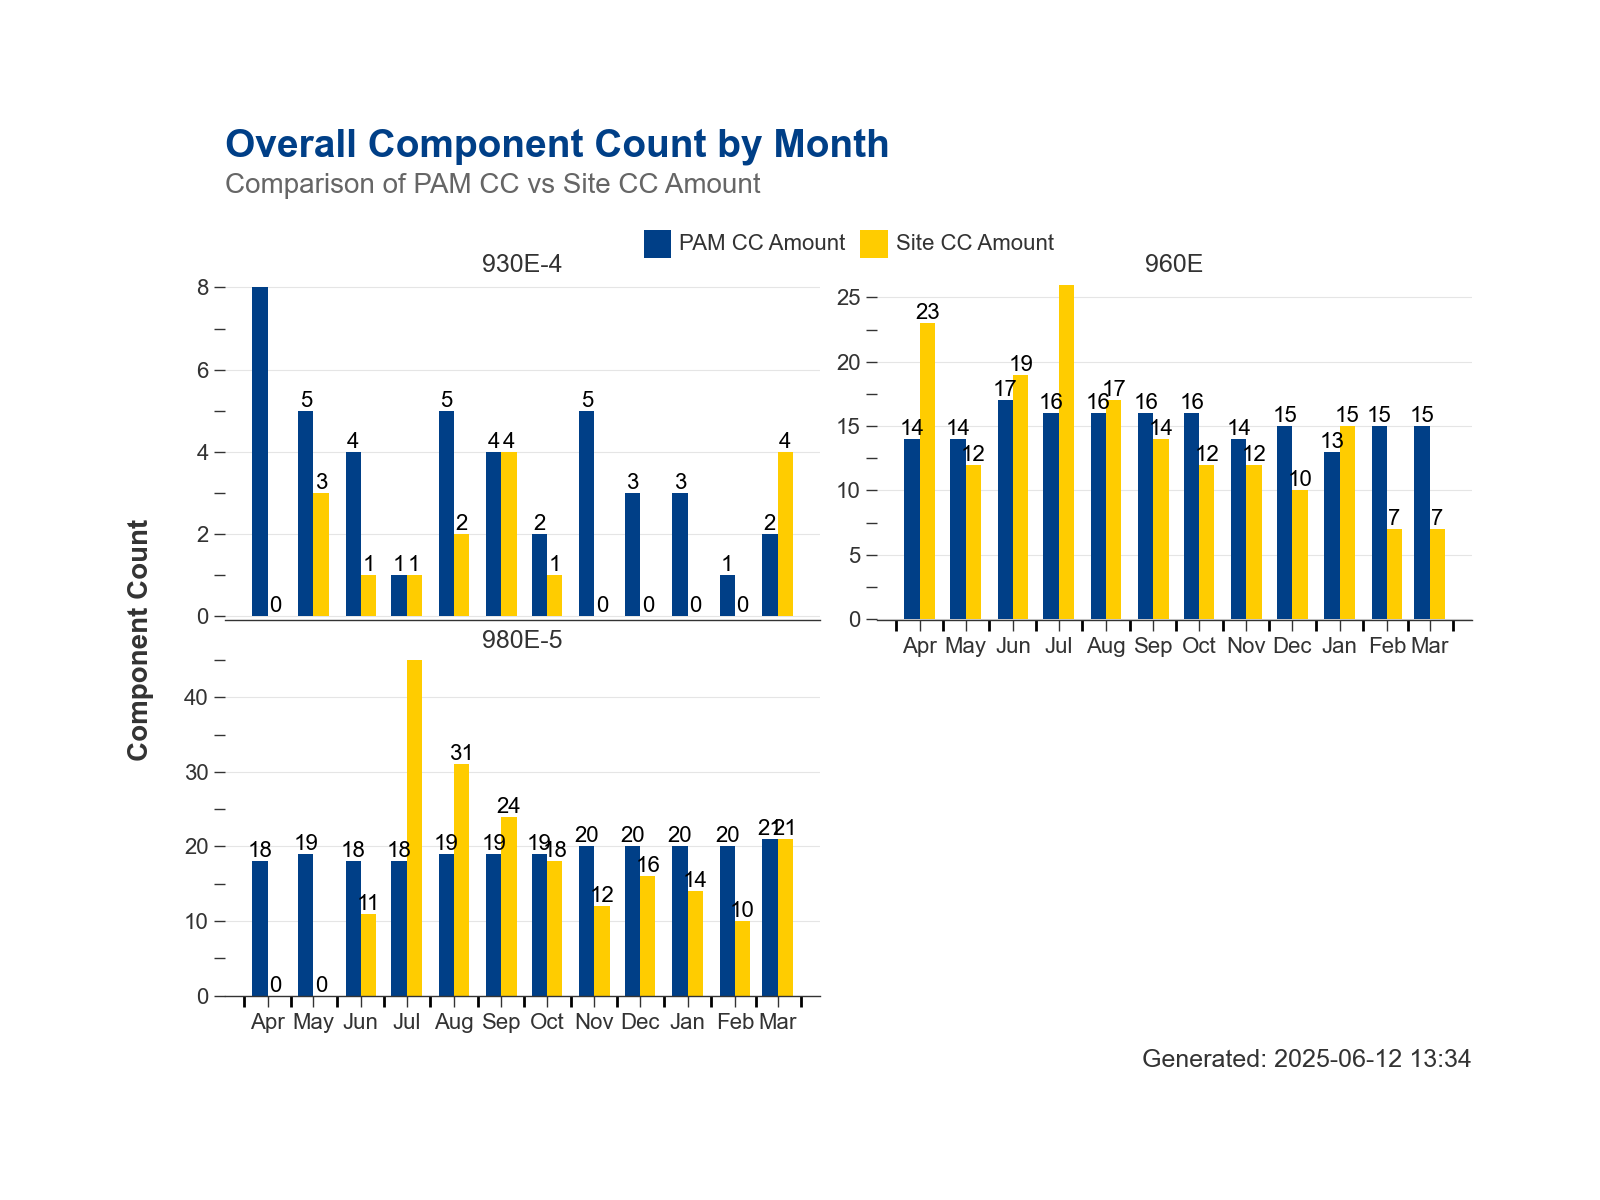

In [11]:
def prepare_monthly_data(df, group_cols=["site_name", "model_name", "month_date"]):
    """
    Prepare data for monthly aggregation

    Args:
        df: Polars DataFrame
        group_cols: List of columns to group by

    Returns:
        Polars DataFrame with aggregated data
    """
    # Aggregate the data
    agg_df = (
        df.group_by(group_cols)
        .agg(
            [
                pl.col("proj_cc_amount").sum().alias("proj_cc_total"),
                pl.col("cc_amount").sum().alias("cc_total"),
            ]
        )
        .sort(group_cols)
    )

    # Melt the data for grouped bar plot
    melted_df = agg_df.melt(
        id_vars=group_cols,
        value_vars=["proj_cc_total", "cc_total"],
        variable_name="metric",
        value_name="count",
    )

    # Clean up metric names for display
    melted_df = melted_df.with_columns(
        pl.when(pl.col("metric") == "proj_cc_total")
        .then(pl.lit("PAM CC Amount"))
        .when(pl.col("metric") == "cc_total")
        .then(pl.lit("Site CC Amount"))
        .otherwise(pl.col("metric"))
        .alias("metric_label")
    )

    return melted_df


def create_monthly_grouped_bars(df, title="", subtitle="", figure_size=(8, 6)):
    """
    Create grouped bar plot for monthly CC amounts by site

    Args:
        df: Prepared DataFrame from prepare_monthly_data
        title: Plot title
        subtitle: Plot subtitle
        figure_size: Tuple of (width, height)

    Returns:
        plotnine plot object
    """
    # Convert to pandas for plotnine
    pandas_df = df.to_pandas()

    # Create the plot
    plot = (
        p9.ggplot(pandas_df, p9.aes(x="month_date", y="count", fill="metric_label"))
        + p9.geom_col(position="dodge", width=20)  # Adjust width for your data
        + p9.facet_wrap("~model_name", scales="free_y", ncol=2)
        # Add value labels
        + p9.geom_text(
            p9.aes(label="count"),
            position=p9.position_dodge(width=20),
            va="bottom",
            size=8,
            format_string="{:.0f}",
        )
        # Color scale
        + p9.scale_fill_manual(
            values={
                "PAM CC Amount": KOMATSU_COLORS["primary_blue"],
                "Site CC Amount": KOMATSU_COLORS["primary_yellow"],
            },
            name="",
        )
        # X-axis formatting
        + p9.scale_x_date(date_labels="%b", date_breaks="1 month")
        # Y-axis formatting
        + p9.scale_y_continuous(expand=(0, 0.1))  # Add some space for labels
        # Labels
        + p9.labs(
            title=title,
            subtitle=subtitle,
            x="",
            y="Component Count",
            caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
        )
        + theme_komatsu(figure_size=figure_size)
    )

    return plot


melted_df = prepare_monthly_data(monthly_df)
overall_plot = create_monthly_grouped_bars(
    melted_df,
    title="Overall Component Count by Month",
    subtitle="Comparison of PAM CC vs   Site CC Amount",
)
overall_plot

In [20]:
pl.read_excel(
    r"C:\Users\andmn\PycharmProjects\kbooks\component_data_raw_980E.xlsx"
).filter(pl.col("week") == "W26-2025")

component_name,week,changeout_date
str,str,date
"""blower_parrilla""","""W26-2025""",2025-06-30
"""suspension_trasera""","""W26-2025""",2025-06-30


In [14]:
monthly_df.filter(pl.col("site_name") == "SPENCE")

site_name,model_name,component_name,month_date,pam_repair_cost,prorrata_sale,proj_cc_amount,site_repair_cost,site_sale,cc_amount
str,str,str,date,i64,i64,i64,i64,i64,i64
"""SPENCE""","""980E-5""","""motor_traccion""",2025-04-01,0,807362,2,null,null,null
"""SPENCE""","""980E-5""","""cilindro_direccion""",2025-04-01,41022,49704,4,null,null,null
"""SPENCE""","""980E-5""","""cilindro_levante""",2025-04-01,57295,125736,4,null,null,null
"""SPENCE""","""980E-5""","""conjunto_maza_suspension""",2025-04-01,313228,391304,2,null,null,null
"""SPENCE""","""980E-5""","""blower_parrilla""",2025-04-01,28012,111204,3,null,null,null
…,…,…,…,…,…,…,…,…,…
"""SPENCE""","""980E-5""","""suspension_delantera""",2025-08-01,null,null,null,0,0,4
"""SPENCE""","""980E-5""","""suspension_delantera""",2025-12-01,null,null,null,0,0,3
"""SPENCE""","""980E-5""","""suspension_delantera""",2026-02-01,null,null,null,0,0,2


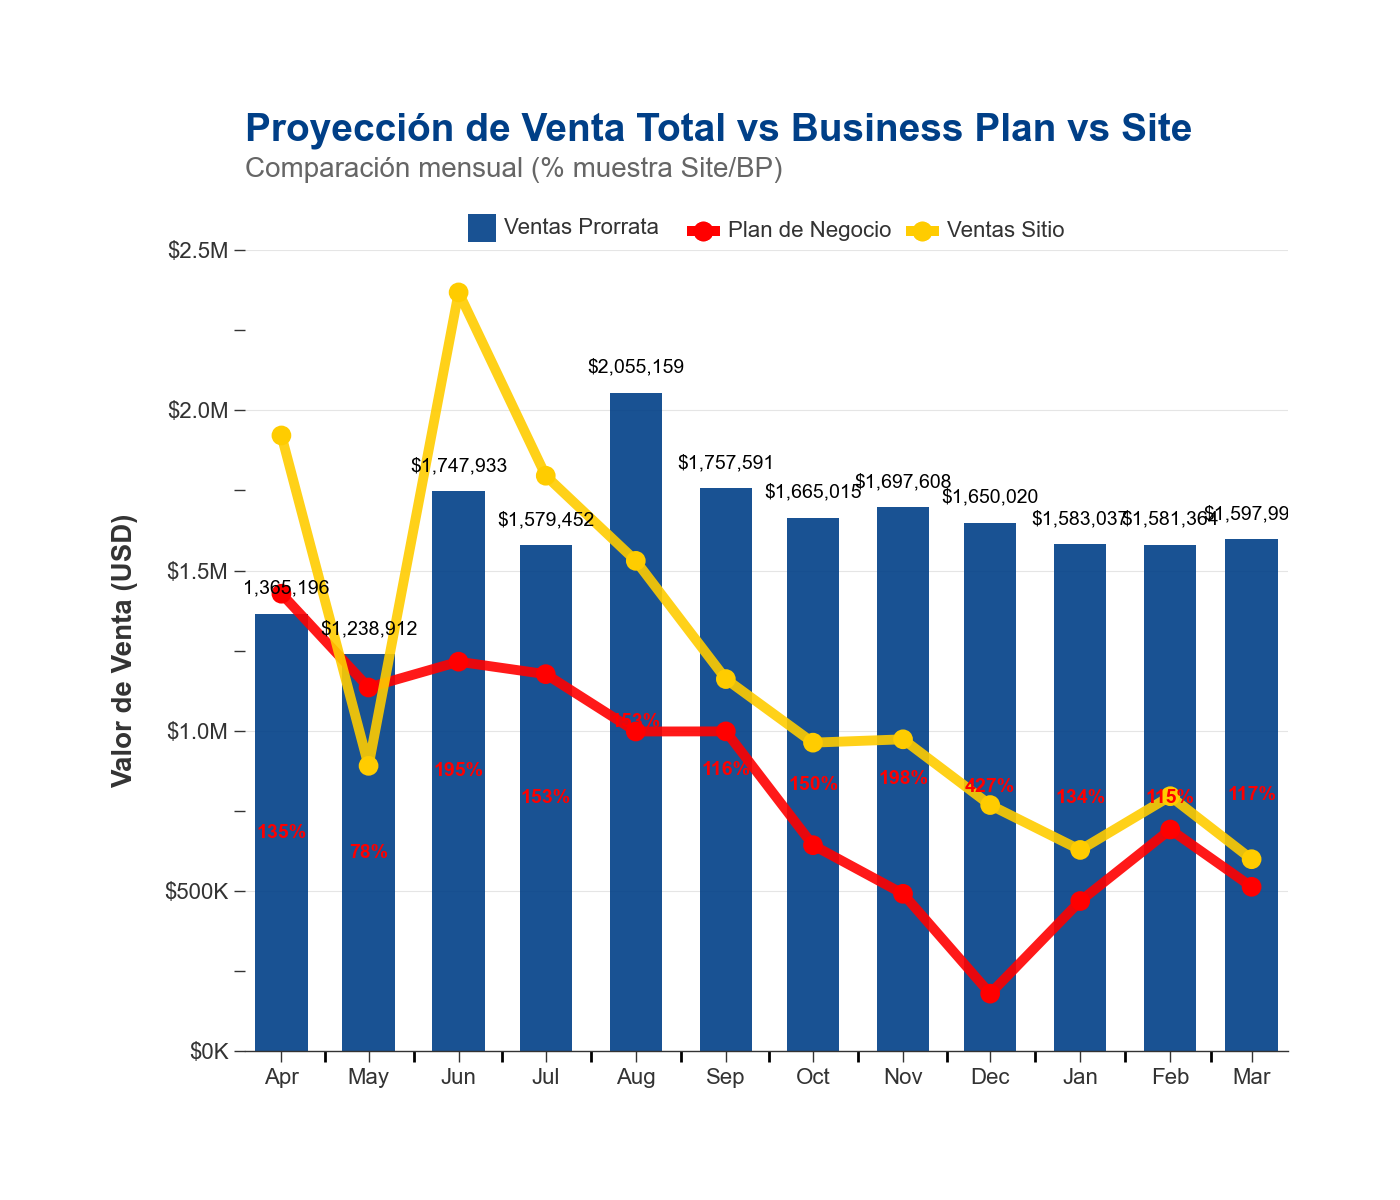

In [22]:
# Create the plot
pandas_df = site_monthly_df.filter(pl.col("site_name") == "MEL").to_pandas()
# Calculate percentage of site_sale vs bp_sale
pandas_df["site_vs_bp_pct"] = (
    pandas_df["site_sale"] / pandas_df["bp_sale"] * 100
).round(1)

# Create the enhanced plot
plot = (
    p9.ggplot(pandas_df, p9.aes(x="month_date"))
    # Bar plot for prorrata_sale
    + p9.geom_col(
        p9.aes(y="prorrata_sale", fill='"Ventas Prorrata"'),
        width=18,  # Adjusted for 7-inch width
        alpha=0.9,
    )
    # Line plot for bp_sale (red)
    + p9.geom_line(p9.aes(y="bp_sale", color='"Plan de Negocio"'), size=2, alpha=0.9)
    + p9.geom_point(p9.aes(y="bp_sale", color='"Plan de Negocio"'), size=3, shape="o")
    # Line plot for site_sale (yellow)
    + p9.geom_line(p9.aes(y="site_sale", color='"Ventas Sitio"'), size=2, alpha=0.9)
    + p9.geom_point(p9.aes(y="site_sale", color='"Ventas Sitio"'), size=3, shape="o")
    # Add value labels on bars - BALANCED SIZE
    + p9.geom_text(
        p9.aes(y="prorrata_sale", label="prorrata_sale"),
        va="bottom",
        size=7,  # Increased
        format_string="${:,.0f}",
        nudge_y=50000,  # Adjusted nudge
        fontweight="normal",
    )
    # Add percentage labels inside bars - BALANCED SIZE
    + p9.geom_text(
        p9.aes(y="prorrata_sale/2", label="site_vs_bp_pct"),
        va="center",
        ha="center",
        size=7,  # Increased
        color="#FF0000",
        fontweight="bold",
        format_string="{:.0f}%",
    )
    # Color and fill scales
    + p9.scale_fill_manual(
        values={"Ventas Prorrata": KOMATSU_COLORS["primary_blue"]}, name=""
    )
    + p9.scale_color_manual(
        values={
            "Plan de Negocio": "#FF0000",  # Red
            "Ventas Sitio": KOMATSU_COLORS["primary_yellow"],  # Yellow
        },
        name="",
    )
    # X-axis formatting - SMALLER LABELS
    + p9.scale_x_date(
        date_labels="%b",  # Just month abbreviation, no year
        date_breaks="1 month",
        expand=(0.01, 0.01),  # Very tight padding
    )
    # Y-axis formatting - CLEANER BREAKS
    + p9.scale_y_continuous(
        labels=lambda l: [
            f"${v/1000000:.1f}M" if v >= 1000000 else f"${v/1000:.0f}K" for v in l
        ],
        limits=(0, 2500000),
        breaks=[0, 500000, 1000000, 1500000, 2000000, 2500000],
        expand=(0, 0.02),
    )
    # Labels - BALANCED TITLES
    + p9.labs(
        title="Proyección de Venta Total vs Business Plan vs Site",
        subtitle="Comparación mensual (% muestra Site/BP)",  # Slightly longer
        x="",
        y="Valor de Venta (USD)",
        caption="",
    )
    + theme_komatsu(figure_size=(7, 6))  # Requested size
    # Legend guides
    + p9.guides(
        fill=p9.guide_legend(order=1, ncol=1), color=p9.guide_legend(order=2, ncol=2)
    )
)

plot

In [107]:
monthly_df.filter(pl.col("site_name") == "SPENCE")["site_sale"].sum()

19841122

In [106]:
monthly_df.filter(pl.col("site_name") == "SPENCE")["site_repair_cost"].sum()

19710137

### Spence

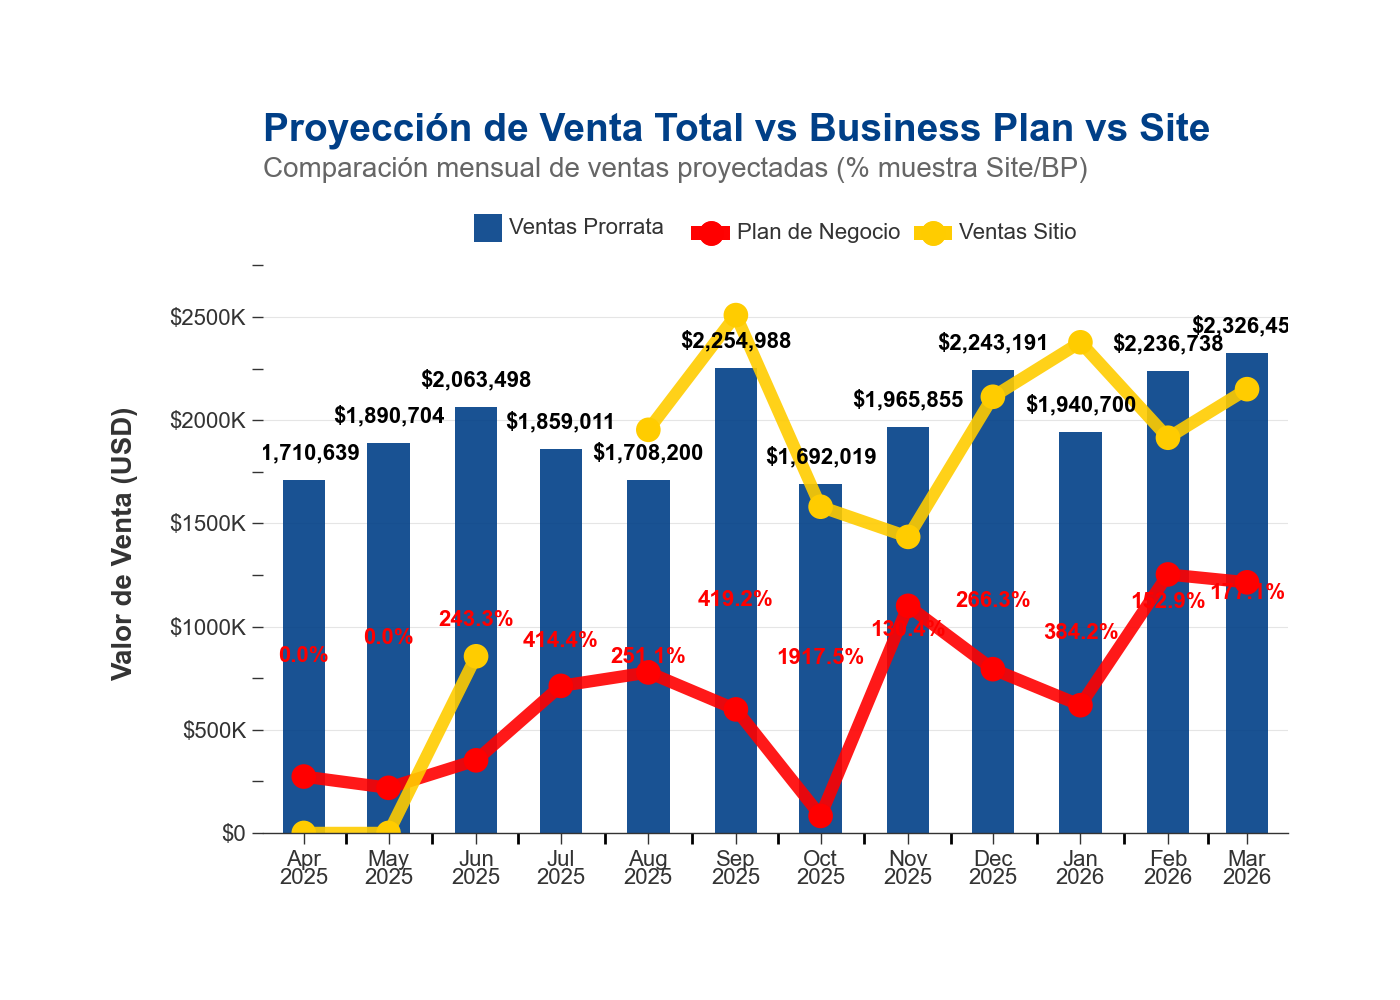

In [78]:
# Create the plot
pandas_df = site_monthly_df.filter(pl.col("site_name") == "SPENCE").to_pandas()
# Calculate percentage of site_sale vs bp_sale
pandas_df["site_vs_bp_pct"] = (
    pandas_df["site_sale"] / pandas_df["bp_sale"] * 100
).round(1)

# Create the enhanced plot
plot = (
    p9.ggplot(pandas_df, p9.aes(x="month_date"))
    # Bar plot for prorrata_sale with better styling
    + p9.geom_col(
        p9.aes(y="prorrata_sale", fill='"Ventas Prorrata"'),
        width=15,  # Narrower bars
        alpha=0.9,
    )
    # Line plot for bp_sale (black) with enhanced styling
    + p9.geom_line(p9.aes(y="bp_sale", color='"Plan de Negocio"'), size=2.5, alpha=0.9)
    + p9.geom_point(p9.aes(y="bp_sale", color='"Plan de Negocio"'), size=4, shape="o")
    # Line plot for site_sale (yellow) with enhanced styling
    + p9.geom_line(p9.aes(y="site_sale", color='"Ventas Sitio"'), size=2.5, alpha=0.9)
    + p9.geom_point(p9.aes(y="site_sale", color='"Ventas Sitio"'), size=4, shape="o")
    # Add value labels on bars with better positioning
    + p9.geom_text(
        p9.aes(y="prorrata_sale", label="prorrata_sale"),
        va="bottom",
        size=8,
        format_string="${:,.0f}",
        nudge_y=80000,
        fontweight="bold",
    )
    # Add percentage labels inside the bars (site vs bp percentage)
    + p9.geom_text(
        p9.aes(y="prorrata_sale/2", label="site_vs_bp_pct"),
        va="center",
        ha="center",
        size=8,
        color="#FF0000",  # Red color for percentages
        fontweight="bold",
        format_string="{:.1f}%",
    )
    # Color and fill scales with better colors
    + p9.scale_fill_manual(
        values={"Ventas Prorrata": KOMATSU_COLORS["primary_blue"]}, name=""
    )
    + p9.scale_color_manual(
        values={
            "Plan de Negocio": "#FF0000",  # Red for Business Plan
            "Ventas Sitio": KOMATSU_COLORS["primary_yellow"],  # Komatsu Yellow
        },
        name="",
    )
    # Improved axis formatting
    + p9.scale_x_date(
        date_labels="%b\n%Y", date_breaks="1 month", expand=(0.02, 0.02)  # Less padding
    )
    + p9.scale_y_continuous(
        labels=lambda l: [f"${v/1000:.0f}K" if v >= 1000 else f"${v:.0f}" for v in l],
        limits=(0, 2800000),
        breaks=[0, 500000, 1000000, 1500000, 2000000, 2500000],
        expand=(0, 0.05),
    )
    # Labels with better spacing
    + p9.labs(
        title="Proyección de Venta Total vs Business Plan vs Site",
        subtitle="Comparación mensual de ventas proyectadas (% muestra Site/BP)",
        x="",  # Remove x label for cleaner look
        y="Valor de Venta (USD)",
        caption="",  # Remove caption for cleaner look
    )
    + theme_komatsu(figure_size=(7, 5))  # Wider but shorter
    # Additional customizations
    + p9.guides(fill=p9.guide_legend(order=1), color=p9.guide_legend(order=2))
)
plot

## Costos

|### Escondida

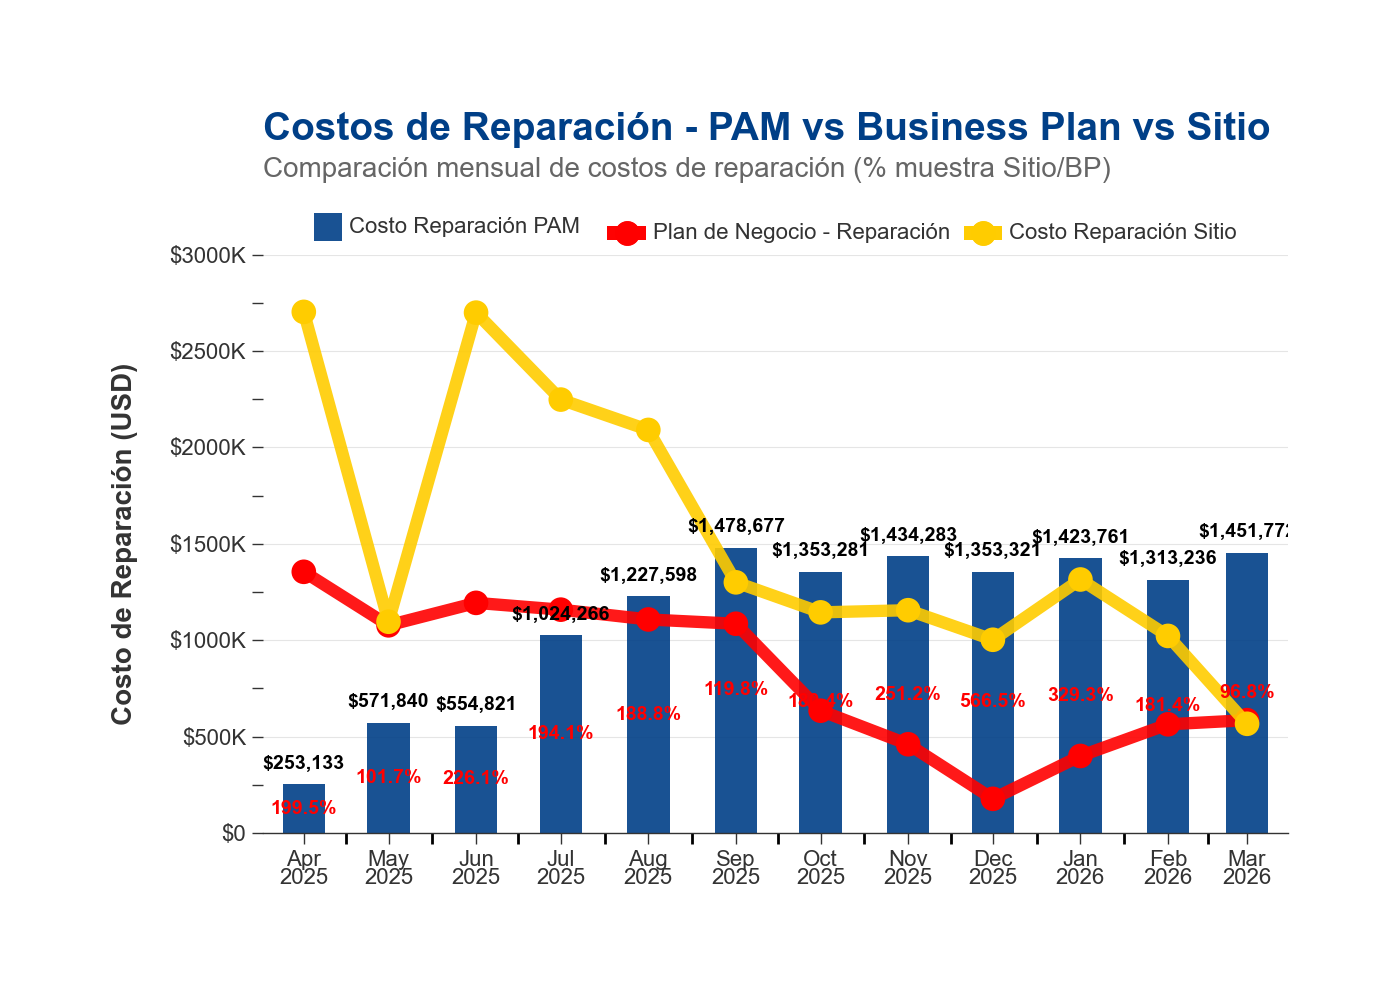

In [25]:
pandas_df = site_monthly_df.filter(pl.col("site_name") == "MEL").to_pandas()
pandas_df["site_vs_bp_repair_pct"] = (
    pandas_df["site_repair_cost"] / pandas_df["bp_repair_cost"] * 100
).round(1)
# Create the enhanced plot with repair costs
plot = (
    p9.ggplot(pandas_df, p9.aes(x="month_date"))
    # Bar plot for pam_repair_cost with Komatsu blue
    + p9.geom_col(
        p9.aes(y="pam_repair_cost", fill='"Costo Reparación PAM"'),
        width=15,  # Narrower bars
        alpha=0.9,
    )
    # Line plot for bp_repair_cost (red) with enhanced styling
    + p9.geom_line(
        p9.aes(y="bp_repair_cost", color='"Plan de Negocio - Reparación"'),
        size=2.5,
        alpha=0.9,
    )
    + p9.geom_point(
        p9.aes(y="bp_repair_cost", color='"Plan de Negocio - Reparación"'),
        size=4,
        shape="o",
    )
    # Line plot for site_repair_cost (yellow) with enhanced styling
    + p9.geom_line(
        p9.aes(y="site_repair_cost", color='"Costo Reparación Sitio"'),
        size=2.5,
        alpha=0.9,
    )
    + p9.geom_point(
        p9.aes(y="site_repair_cost", color='"Costo Reparación Sitio"'),
        size=4,
        shape="o",
    )
    # Add value labels on bars with better positioning
    + p9.geom_text(
        p9.aes(y="pam_repair_cost", label="pam_repair_cost"),
        va="bottom",
        size=7,  # Smaller text
        format_string="${:,.0f}",
        nudge_y=60000,  # Reduced nudge
        fontweight="bold",
    )
    # Add percentage labels inside the bars (site repair vs bp repair percentage)
    + p9.geom_text(
        data=pandas_df,  # Explicitly pass the dataframe
        mapping=p9.aes(
            x="month_date",
            y=pandas_df["pam_repair_cost"] / 2,
            label="site_vs_bp_repair_pct",
        ),
        va="center",
        ha="center",
        size=7,  # Smaller text
        color="#FF0000",  # Red color for percentages
        fontweight="bold",
        format_string="{:.1f}%",
        inherit_aes=False,  # Don't inherit aesthetics from main plot
    )
    # Color and fill scales with better colors
    + p9.scale_fill_manual(
        values={"Costo Reparación PAM": KOMATSU_COLORS["primary_blue"]}, name=""
    )
    + p9.scale_color_manual(
        values={
            "Plan de Negocio - Reparación": "#FF0000",  # Red for Business Plan
            "Costo Reparación Sitio": KOMATSU_COLORS[
                "primary_yellow"
            ],  # Komatsu Yellow
        },
        name="",
    )
    # Improved axis formatting
    + p9.scale_x_date(
        date_labels="%b\n%Y", date_breaks="1 month", expand=(0.02, 0.02)  # Less padding
    )
    + p9.scale_y_continuous(
        labels=lambda l: [f"${v/1000:.0f}K" if v >= 1000 else f"${v:.0f}" for v in l],
        limits=(0, 3000000),  # Adjusted for repair cost ranges
        breaks=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000],
        expand=(0, 0.05),
    )
    # Labels with better spacing
    + p9.labs(
        title="Costos de Reparación - PAM vs Business Plan vs Sitio",
        subtitle="Comparación mensual de costos de reparación (% muestra Sitio/BP)",
        x="",  # Remove x label for cleaner look
        y="Costo de Reparación (USD)",
        caption="",  # Remove caption for cleaner look
    )
    + theme_komatsu(figure_size=(7, 5))  # Reduced size for Quarto
    # Additional customizations
    + p9.guides(fill=p9.guide_legend(order=1), color=p9.guide_legend(order=2))
)
plot

### Spence

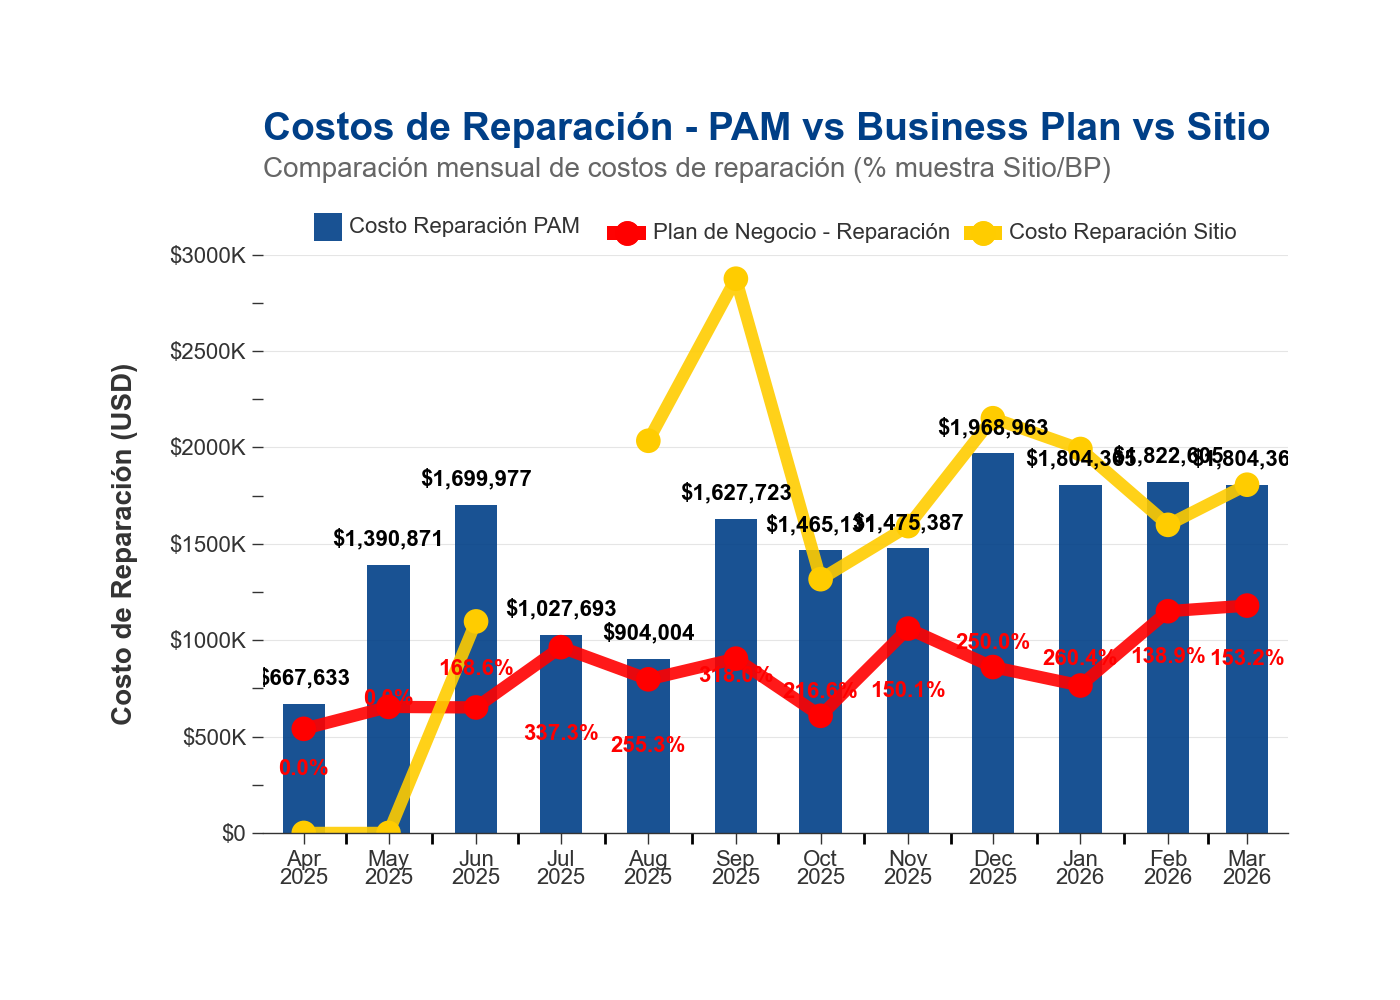

In [79]:
pandas_df = site_monthly_df.filter(pl.col("site_name") == "SPENCE").to_pandas()
pandas_df["site_vs_bp_repair_pct"] = (
    pandas_df["site_repair_cost"] / pandas_df["bp_repair_cost"] * 100
).round(1)

# Create the enhanced plot with repair costs
# Create the enhanced plot with repair costs
plot = (
    p9.ggplot(pandas_df, p9.aes(x="month_date"))
    # Bar plot for pam_repair_cost with Komatsu blue
    + p9.geom_col(
        p9.aes(y="pam_repair_cost", fill='"Costo Reparación PAM"'),
        width=15,  # Narrower bars
        alpha=0.9,
    )
    # Line plot for bp_repair_cost (red) with enhanced styling
    + p9.geom_line(
        p9.aes(y="bp_repair_cost", color='"Plan de Negocio - Reparación"'),
        size=2.5,
        alpha=0.9,
    )
    + p9.geom_point(
        p9.aes(y="bp_repair_cost", color='"Plan de Negocio - Reparación"'),
        size=4,
        shape="o",
    )
    # Line plot for site_repair_cost (yellow) with enhanced styling
    + p9.geom_line(
        p9.aes(y="site_repair_cost", color='"Costo Reparación Sitio"'),
        size=2.5,
        alpha=0.9,
    )
    + p9.geom_point(
        p9.aes(y="site_repair_cost", color='"Costo Reparación Sitio"'),
        size=4,
        shape="o",
    )
    # Add value labels on bars with better positioning
    + p9.geom_text(
        p9.aes(y="pam_repair_cost", label="pam_repair_cost"),
        va="bottom",
        size=8,
        format_string="${:,.0f}",
        nudge_y=80000,
        fontweight="bold",
    )
    # Add percentage labels inside the bars (site repair vs bp repair percentage)
    + p9.geom_text(
        data=pandas_df,  # Explicitly pass the dataframe
        mapping=p9.aes(
            x="month_date",
            y=pandas_df["pam_repair_cost"] / 2,
            label="site_vs_bp_repair_pct",
        ),
        va="center",
        ha="center",
        size=8,
        color="#FF0000",  # Red color for percentages
        fontweight="bold",
        format_string="{:.1f}%",
        inherit_aes=False,  # Don't inherit aesthetics from main plot
    )
    # Color and fill scales with better colors
    + p9.scale_fill_manual(
        values={"Costo Reparación PAM": KOMATSU_COLORS["primary_blue"]}, name=""
    )
    + p9.scale_color_manual(
        values={
            "Plan de Negocio - Reparación": "#FF0000",  # Red for Business Plan
            "Costo Reparación Sitio": KOMATSU_COLORS[
                "primary_yellow"
            ],  # Komatsu Yellow
        },
        name="",
    )
    # Improved axis formatting
    + p9.scale_x_date(
        date_labels="%b\n%Y", date_breaks="1 month", expand=(0.02, 0.02)  # Less padding
    )
    + p9.scale_y_continuous(
        labels=lambda l: [f"${v/1000:.0f}K" if v >= 1000 else f"${v:.0f}" for v in l],
        limits=(0, 3000000),  # Adjusted for repair cost ranges
        breaks=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000],
        expand=(0, 0.05),
    )
    # Labels with better spacing
    + p9.labs(
        title="Costos de Reparación - PAM vs Business Plan vs Sitio",
        subtitle="Comparación mensual de costos de reparación (% muestra Sitio/BP)",
        x="",  # Remove x label for cleaner look
        y="Costo de Reparación (USD)",
        caption="",  # Remove caption for cleaner look
    )
    + theme_komatsu(figure_size=(7, 5))
    # Additional customizations
    + p9.guides(fill=p9.guide_legend(order=1), color=p9.guide_legend(order=2))
)
plot

In [6]:
site_monthly_df.head(3).to_dicts()

[{'site_name': 'MEL',
  'month_date': datetime.date(2025, 4, 1),
  'pam_repair_cost': 253133,
  'prorrata_sale': 1365196,
  'pam_cc_amount': 22,
  'site_repair_cost': 2702634,
  'site_sale': 1921691,
  'cc_amount': 23,
  'bp_sale': 1427906,
  'bp_repair_cost': 1354432},
 {'site_name': 'MEL',
  'month_date': datetime.date(2025, 5, 1),
  'pam_repair_cost': 571840,
  'prorrata_sale': 1238912,
  'pam_cc_amount': 19,
  'site_repair_cost': 1095439,
  'site_sale': 890823,
  'cc_amount': 11,
  'bp_sale': 1135285,
  'bp_repair_cost': 1076833},
 {'site_name': 'MEL',
  'month_date': datetime.date(2025, 6, 1),
  'pam_repair_cost': 554821,
  'prorrata_sale': 1747933,
  'pam_cc_amount': 21,
  'site_repair_cost': 2698705,
  'site_sale': 2368042,
  'cc_amount': 20,
  'bp_sale': 1215772,
  'bp_repair_cost': 1193359}]

In [6]:
sale_df

site_name,model_name,component_name,position_name,pam_equipment_name,proj_changeout_date,proj_component_hours,changeout_reason,pam_repair_cost,prorrata_sale,cc_amount
str,str,str,str,str,date,f64,str,f64,f64,i64
"""SPENCE""","""980E-5""","""modulo_potencia""","""unico""","""CA48""",2026-02-01,14167.0,"""unknown""",172363.95,97751.0,1
"""SPENCE""","""980E-5""","""modulo_potencia""","""unico""","""CA54""",2025-12-01,14107.0,"""unknown""",172363.95,97337.0,1
"""SPENCE""","""980E-5""","""modulo_potencia""","""unico""","""CA55""",2025-11-01,16145.0,"""unknown""",172363.95,111399.0,1
"""SPENCE""","""980E-5""","""modulo_potencia""","""unico""","""CA56""",2026-01-01,14632.0,"""unknown""",172363.95,100959.0,1
"""SPENCE""","""980E-5""","""modulo_potencia""","""unico""","""CA50""",2025-11-01,15424.0,"""unknown""",0.0,106424.0,1
…,…,…,…,…,…,…,…,…,…,…
"""MEL""","""960E""","""cilindro_levante""","""derecho""","""TKD879""",2025-05-01,59642.5,"""TBO""",0.0,29098.0,1
"""MEL""","""960E""","""cilindro_direccion""","""derecho""","""TKD880""",2025-11-01,14687.5,"""TBO""",11209.77,10458.0,1
"""MEL""","""960E""","""conjunto_maza_suspension""","""derecho""","""TKD880""",2025-12-01,17111.5,"""unknown""",133377.75,177527.0,1


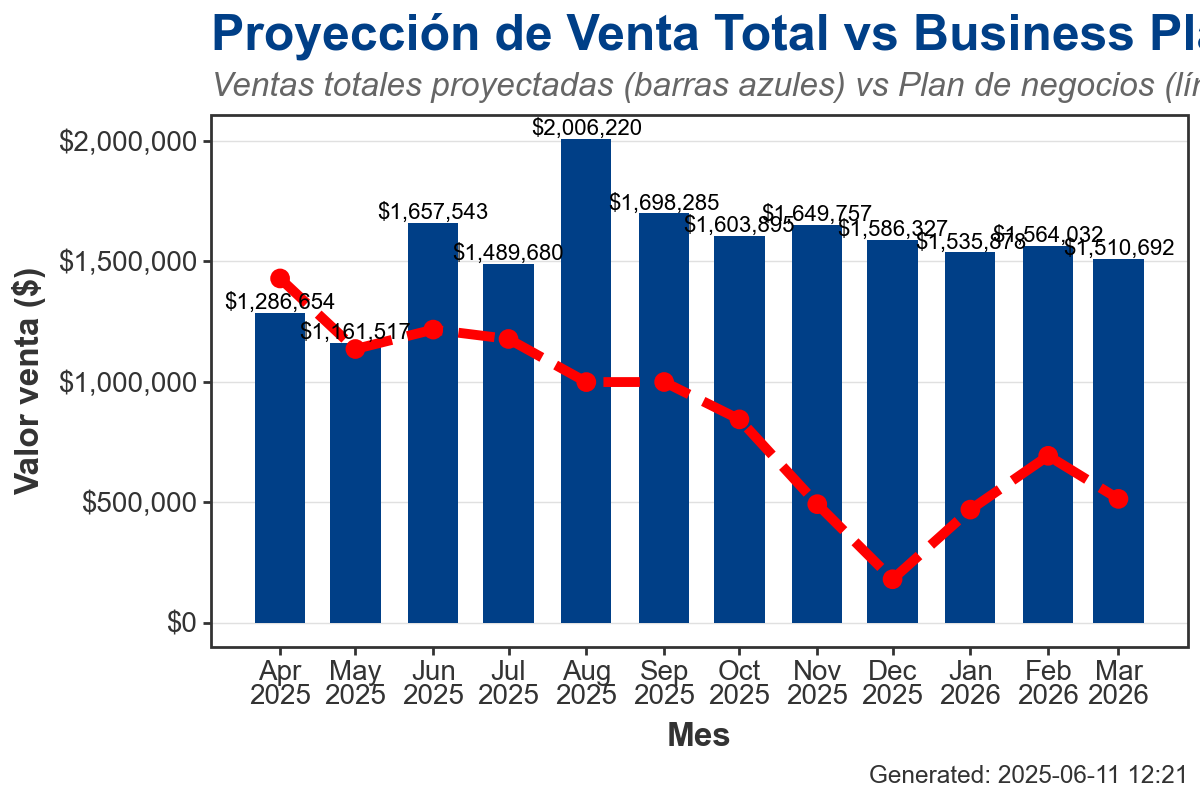

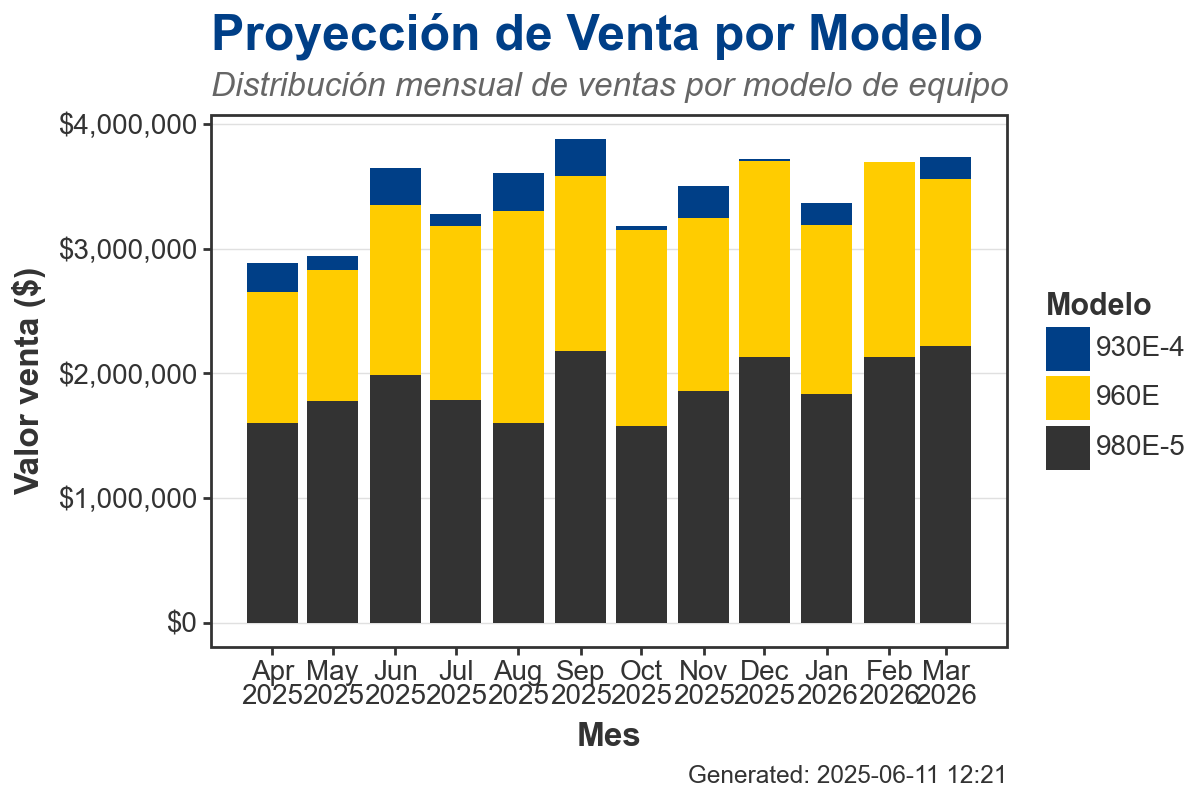

In [10]:
# Prepare business plan data
bp_df = pl.DataFrame(
    [
        {"month_date": "2025-04-01", "business_plan_sale": 1427986},
        {"month_date": "2025-05-01", "business_plan_sale": 1135285},
        {"month_date": "2025-06-01", "business_plan_sale": 1215772},
        {"month_date": "2025-07-01", "business_plan_sale": 1176895},
        {"month_date": "2025-08-01", "business_plan_sale": 998006},
        {"month_date": "2025-09-01", "business_plan_sale": 998347},
        {"month_date": "2025-10-01", "business_plan_sale": 843246},
        {"month_date": "2025-11-01", "business_plan_sale": 491517},
        {"month_date": "2025-12-01", "business_plan_sale": 179980},
        {"month_date": "2026-01-01", "business_plan_sale": 468983},
        {"month_date": "2026-02-01", "business_plan_sale": 692134},
        {"month_date": "2026-03-01", "business_plan_sale": 513376},
    ]
)
bp_df = bp_df.with_columns(pl.col("month_date").str.to_date().alias("month_date"))

# ============================================================================
# PLOT 1: Total Sales vs Business Plan (no stacking)
# ============================================================================
partial_sale_df = sale_df.clone().filter(pl.col("site_name") == "Escondida")
# Aggregate only by month (no grouping)
monthly_totals = (
    partial_sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by("month_date")
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort("month_date")
)

# Create simple bar plot with business plan line
plot1 = (
    p9.ggplot(monthly_totals.to_pandas(), p9.aes(x="month_date", y="prorrata_sale"))
    + p9.geom_col(fill=KOMATSU_COLORS["primary_blue"], width=20)
    # Add business plan line
    + p9.geom_line(
        data=bp_df.to_pandas(),
        mapping=p9.aes(x="month_date", y="business_plan_sale"),
        color="red",
        size=2,
        linetype="dashed",
    )
    + p9.geom_point(
        data=bp_df.to_pandas(),
        mapping=p9.aes(x="month_date", y="business_plan_sale"),
        color="red",
        size=3,
    )
    # Add value labels on bars
    + p9.geom_text(
        p9.aes(label="prorrata_sale"), va="bottom", size=8, format_string="${:,.0f}"
    )
    # Formatting
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta Total vs Business Plan",
        subtitle="Ventas totales proyectadas (barras azules) vs Plan de negocios (línea roja)",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(6, 4))
)

# ============================================================================
# PLOT 3: Stacked by Model Name
# ============================================================================

# Aggregate by month and model
monthly_by_model = (
    partial_sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by(["month_date", "model_name"])
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort(["month_date", "model_name"])
)

# Create stacked bar plot by model
plot3 = (
    p9.ggplot(
        monthly_by_model.to_pandas(),
        p9.aes(x="month_date", y="prorrata_sale", fill="model_name"),
    )
    + p9.geom_col(position="stack")
    + p9.scale_fill_manual(values=COMPONENT_COLORS, name="Modelo")
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta por Modelo",
        subtitle="Distribución mensual de ventas por modelo de equipo",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(6, 4))
)
display(plot1)
display(plot3)

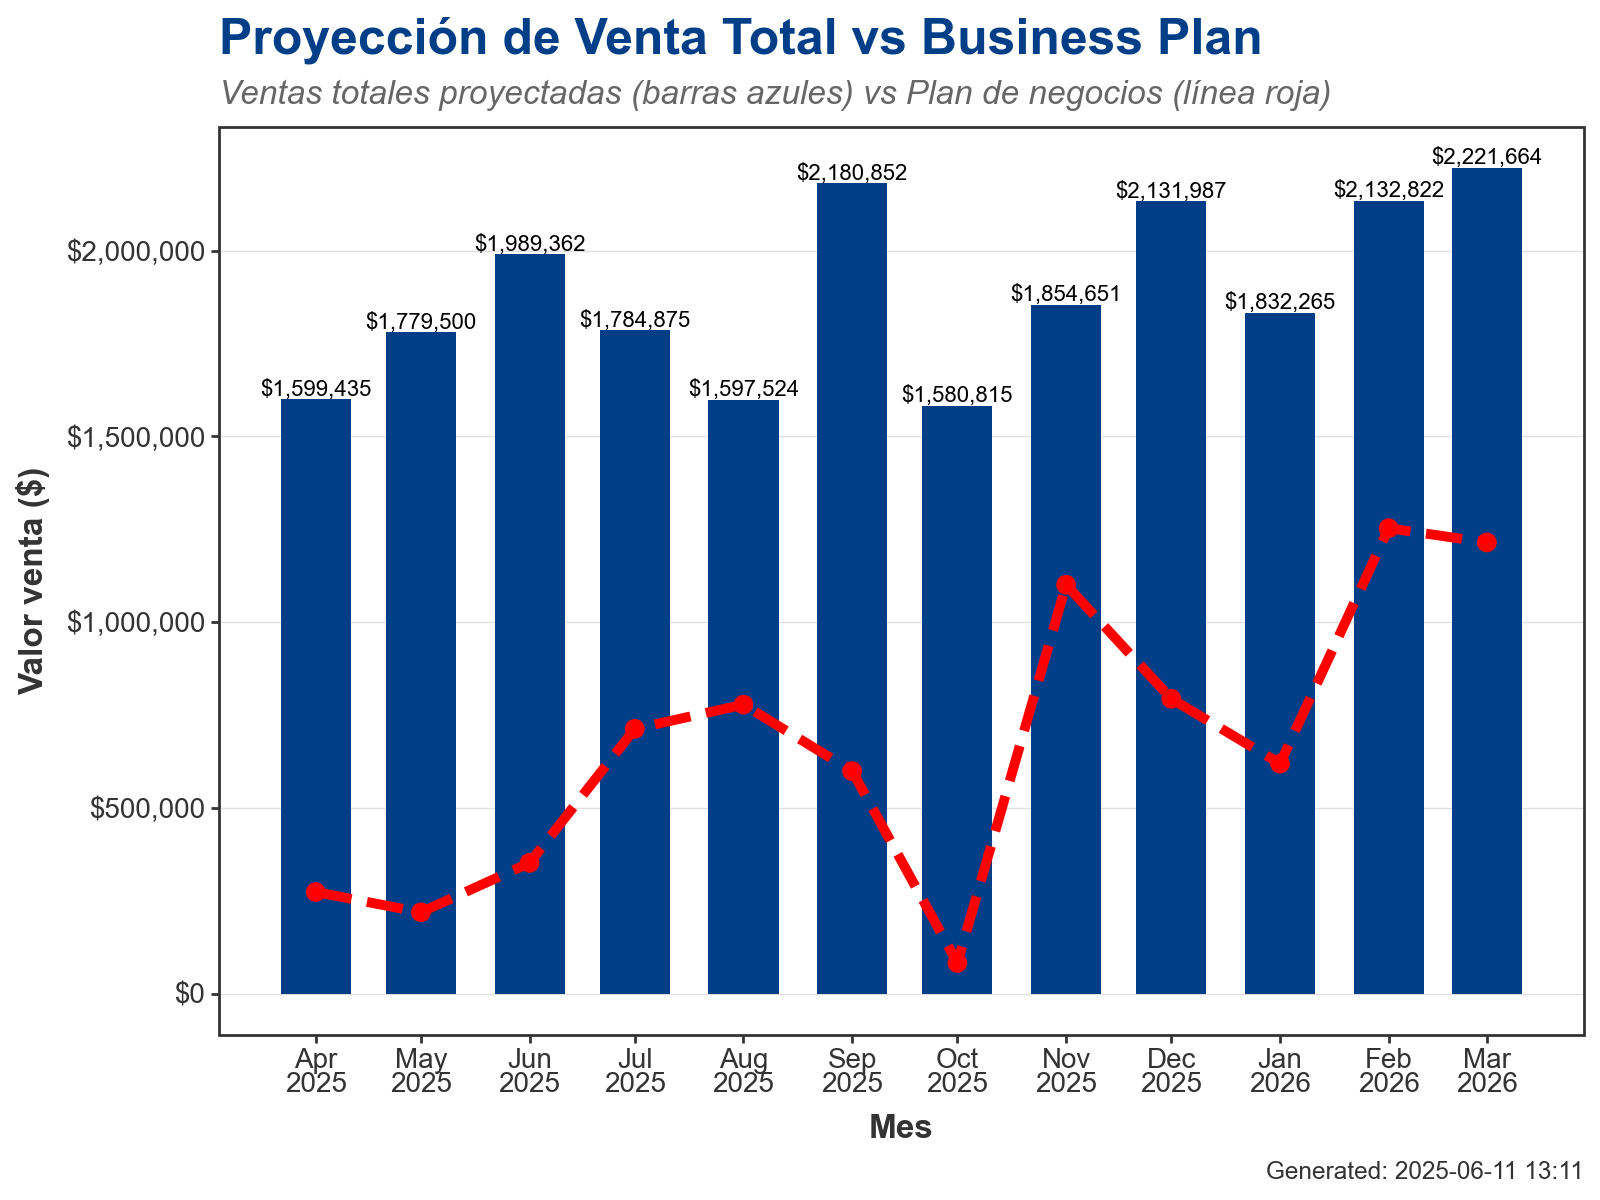

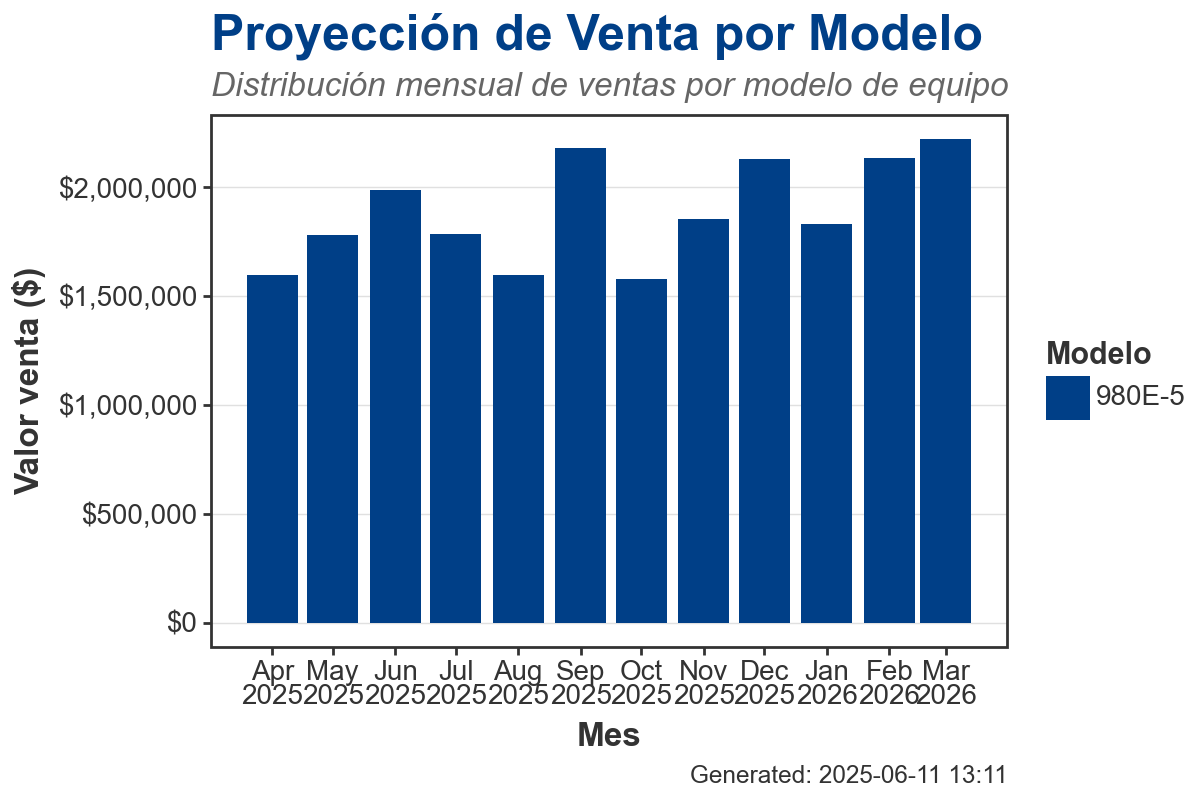

In [15]:
# Prepare business plan data
bp_df = pl.DataFrame(
    [
        {"month_date": "2025-04-01", "business_plan_sale": 273238},
        {"month_date": "2025-05-01", "business_plan_sale": 218614},
        {"month_date": "2025-06-01", "business_plan_sale": 351812},
        {"month_date": "2025-07-01", "business_plan_sale": 712487},
        {"month_date": "2025-08-01", "business_plan_sale": 777726},
        {"month_date": "2025-09-01", "business_plan_sale": 598596},
        {"month_date": "2025-10-01", "business_plan_sale": 82429},
        {"month_date": "2025-11-01", "business_plan_sale": 1100315},
        {"month_date": "2025-12-01", "business_plan_sale": 793449},
        {"month_date": "2026-01-01", "business_plan_sale": 618807},
        {"month_date": "2026-02-01", "business_plan_sale": 1252529},
        {"month_date": "2026-03-01", "business_plan_sale": 1214221},
    ]
)
bp_df = bp_df.with_columns(pl.col("month_date").str.to_date().alias("month_date"))

# ============================================================================
# PLOT 1: Total Sales vs Business Plan (no stacking)
# ============================================================================
partial_sale_df = sale_df.clone().filter(pl.col("site_name") == "Spence")
# Aggregate only by month (no grouping)
monthly_totals = (
    partial_sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by("month_date")
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort("month_date")
)

# Create simple bar plot with business plan line
plot1 = (
    p9.ggplot(monthly_totals.to_pandas(), p9.aes(x="month_date", y="prorrata_sale"))
    + p9.geom_col(fill=KOMATSU_COLORS["primary_blue"], width=20)
    # Add business plan line
    + p9.geom_line(
        data=bp_df.to_pandas(),
        mapping=p9.aes(x="month_date", y="business_plan_sale"),
        color="red",
        size=2,
        linetype="dashed",
    )
    + p9.geom_point(
        data=bp_df.to_pandas(),
        mapping=p9.aes(x="month_date", y="business_plan_sale"),
        color="red",
        size=3,
    )
    # Add value labels on bars
    + p9.geom_text(
        p9.aes(label="prorrata_sale"), va="bottom", size=8, format_string="${:,.0f}"
    )
    # Formatting
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta Total vs Business Plan",
        subtitle="Ventas totales proyectadas (barras azules) vs Plan de negocios (línea roja)",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(8, 6))
)

# ============================================================================
# PLOT 3: Stacked by Model Name
# ============================================================================

# Aggregate by month and model
monthly_by_model = (
    partial_sale_df.with_columns(
        pl.date(
            pl.col("proj_changeout_date").dt.year(),
            pl.col("proj_changeout_date").dt.month(),
            1,
        ).alias("month_date")
    )
    .group_by(["month_date", "model_name"])
    .agg(
        prorrata_sale=pl.col("prorrata_sale").sum(),
        cc_amount=pl.col("cc_amount").sum(),
    )
    .sort(["month_date", "model_name"])
)

# Create stacked bar plot by model
plot3 = (
    p9.ggplot(
        monthly_by_model.to_pandas(),
        p9.aes(x="month_date", y="prorrata_sale", fill="model_name"),
    )
    + p9.geom_col(position="stack")
    + p9.scale_fill_manual(values=COMPONENT_COLORS, name="Modelo")
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Proyección de Venta por Modelo",
        subtitle="Distribución mensual de ventas por modelo de equipo",
        x="Mes",
        y="Valor venta ($)",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(6, 4))
)
display(plot1)
display(plot3)

In [27]:
# Assuming bp_df and monthly_totals are already available as Polars DataFrames
# Join the dataframes
df_merged = monthly_totals.join(bp_df, on="month_date", how="left")

# Calculate variance columns
df_merged = df_merged.with_columns(
    [
        (pl.col("prorrata_sale") - pl.col("business_plan_sale")).alias("variance"),
        (
            (pl.col("prorrata_sale") - pl.col("business_plan_sale"))
            / pl.col("business_plan_sale")
            * 100
        ).alias("variance_pct"),
    ]
)

# Add month name column
df_merged = df_merged.with_columns(
    pl.col("month_date").dt.strftime("%B %Y").alias("month")
)

# Select and reorder columns
df_final = df_merged.select(
    [
        "month",
        "prorrata_sale",
        "business_plan_sale",
        "variance",
        "variance_pct",
        "cc_amount",
    ]
)

# Calculate totals
totals = pl.DataFrame(
    {
        "month": ["Total"],
        "prorrata_sale": [df_final["prorrata_sale"].sum()],
        "business_plan_sale": [df_final["business_plan_sale"].sum()],
        "variance": [df_final["variance"].sum()],
        "variance_pct": [
            (df_final["prorrata_sale"].sum() / df_final["business_plan_sale"].sum() - 1)
            * 100
        ],
        "cc_amount": [df_final["cc_amount"].sum()],
    }
)

# Append totals
df_with_totals = pl.concat([df_final, totals])

# Convert to pandas for GT (GT works with pandas)
df_pandas = df_with_totals.to_pandas()

# Create a simple GT table - minimal formatting to avoid errors
gt_table = (
    GT(df_pandas)
    .tab_header(title="Sales Performance Report")
    .cols_label(
        month="Month",
        prorrata_sale="Pro-rata Sale",
        business_plan_sale="Business Plan",
        variance="Variance ($)",
        variance_pct="Variance (%)",
        cc_amount="CC Count",
    )
    .fmt_currency(
        columns=["prorrata_sale", "business_plan_sale", "variance"], currency="USD"
    )
    .fmt_number(columns=["variance_pct"], decimals=1)
    .fmt_number(columns=["cc_amount"], decimals=0)
)
gt_table

GT(_tbl_data=             month  prorrata_sale  business_plan_sale   variance  \
0       April 2025      1286654.0             1427986  -141332.0   
1         May 2025      1161517.0             1135285    26232.0   
2        June 2025      1657543.0             1215772   441771.0   
3        July 2025      1489680.0             1176895   312785.0   
4      August 2025      2006220.0              998006  1008214.0   
5   September 2025      1698285.0              998347   699938.0   
6     October 2025      1603895.0              843246   760649.0   
7    November 2025      1649757.0              491517  1158240.0   
8    December 2025      1586327.0              179980  1406347.0   
9     January 2026      1535878.0              468983  1066895.0   
10   February 2026      1564032.0              692134   871898.0   
11      March 2026      1510692.0              513376   997316.0   
12           Total     18750480.0            10141527  8608953.0   

    variance_pct  cc_amount  
0      -9.897296         22  
1       2.310609         19  
2      36.336665         21  
3      26.577137         17  
4     101.022840         21  
5      70.109691         20  
6      90.204875         18  
7     235.645970         19  
8     781.390710         18  
9     227.491188         16  
10    125.972427         16  
11    194.266191         17  
12     84.888134        224  , _body=<great_tables._gt_data.Body object at 0x000001D7F2379430>, _boxhead=Boxhead([ColInfo(var='month', type=<ColInfoTypeEnum.default: 1>, column_label='Month', column_align='left', column_width=None), ColInfo(var='prorrata_sale', type=<ColInfoTypeEnum.default: 1>, column_label='Pro-rata Sale', column_align='right', column_width=None), ColInfo(var='business_plan_sale', type=<ColInfoTypeEnum.default: 1>, column_label='Business Plan', column_align='right', column_width=None), ColInfo(var='variance', type=<ColInfoTypeEnum.default: 1>, column_label='Variance ($)', column_align='right', column_width=None), ColInfo(var='variance_pct', type=<ColInfoTypeEnum.default: 1>, column_label='Variance (%)', column_align='right', column_width=None), ColInfo(var='cc_amount', type=<ColInfoTypeEnum.default: 1>, column_label='CC Count', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001D7F205FFE0>, _spanners=Spanners([]), _heading=Heading(title='Sales Performance Report', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001D7F2389AC0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001D7F237B200>, <great_tables._gt_data.FormatInfo object at 0x000001D7F243B5F0>, <great_tables._gt_data.FormatInfo object at 0x000001D7F243BA40>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font


### Anális
 por cambio y costo

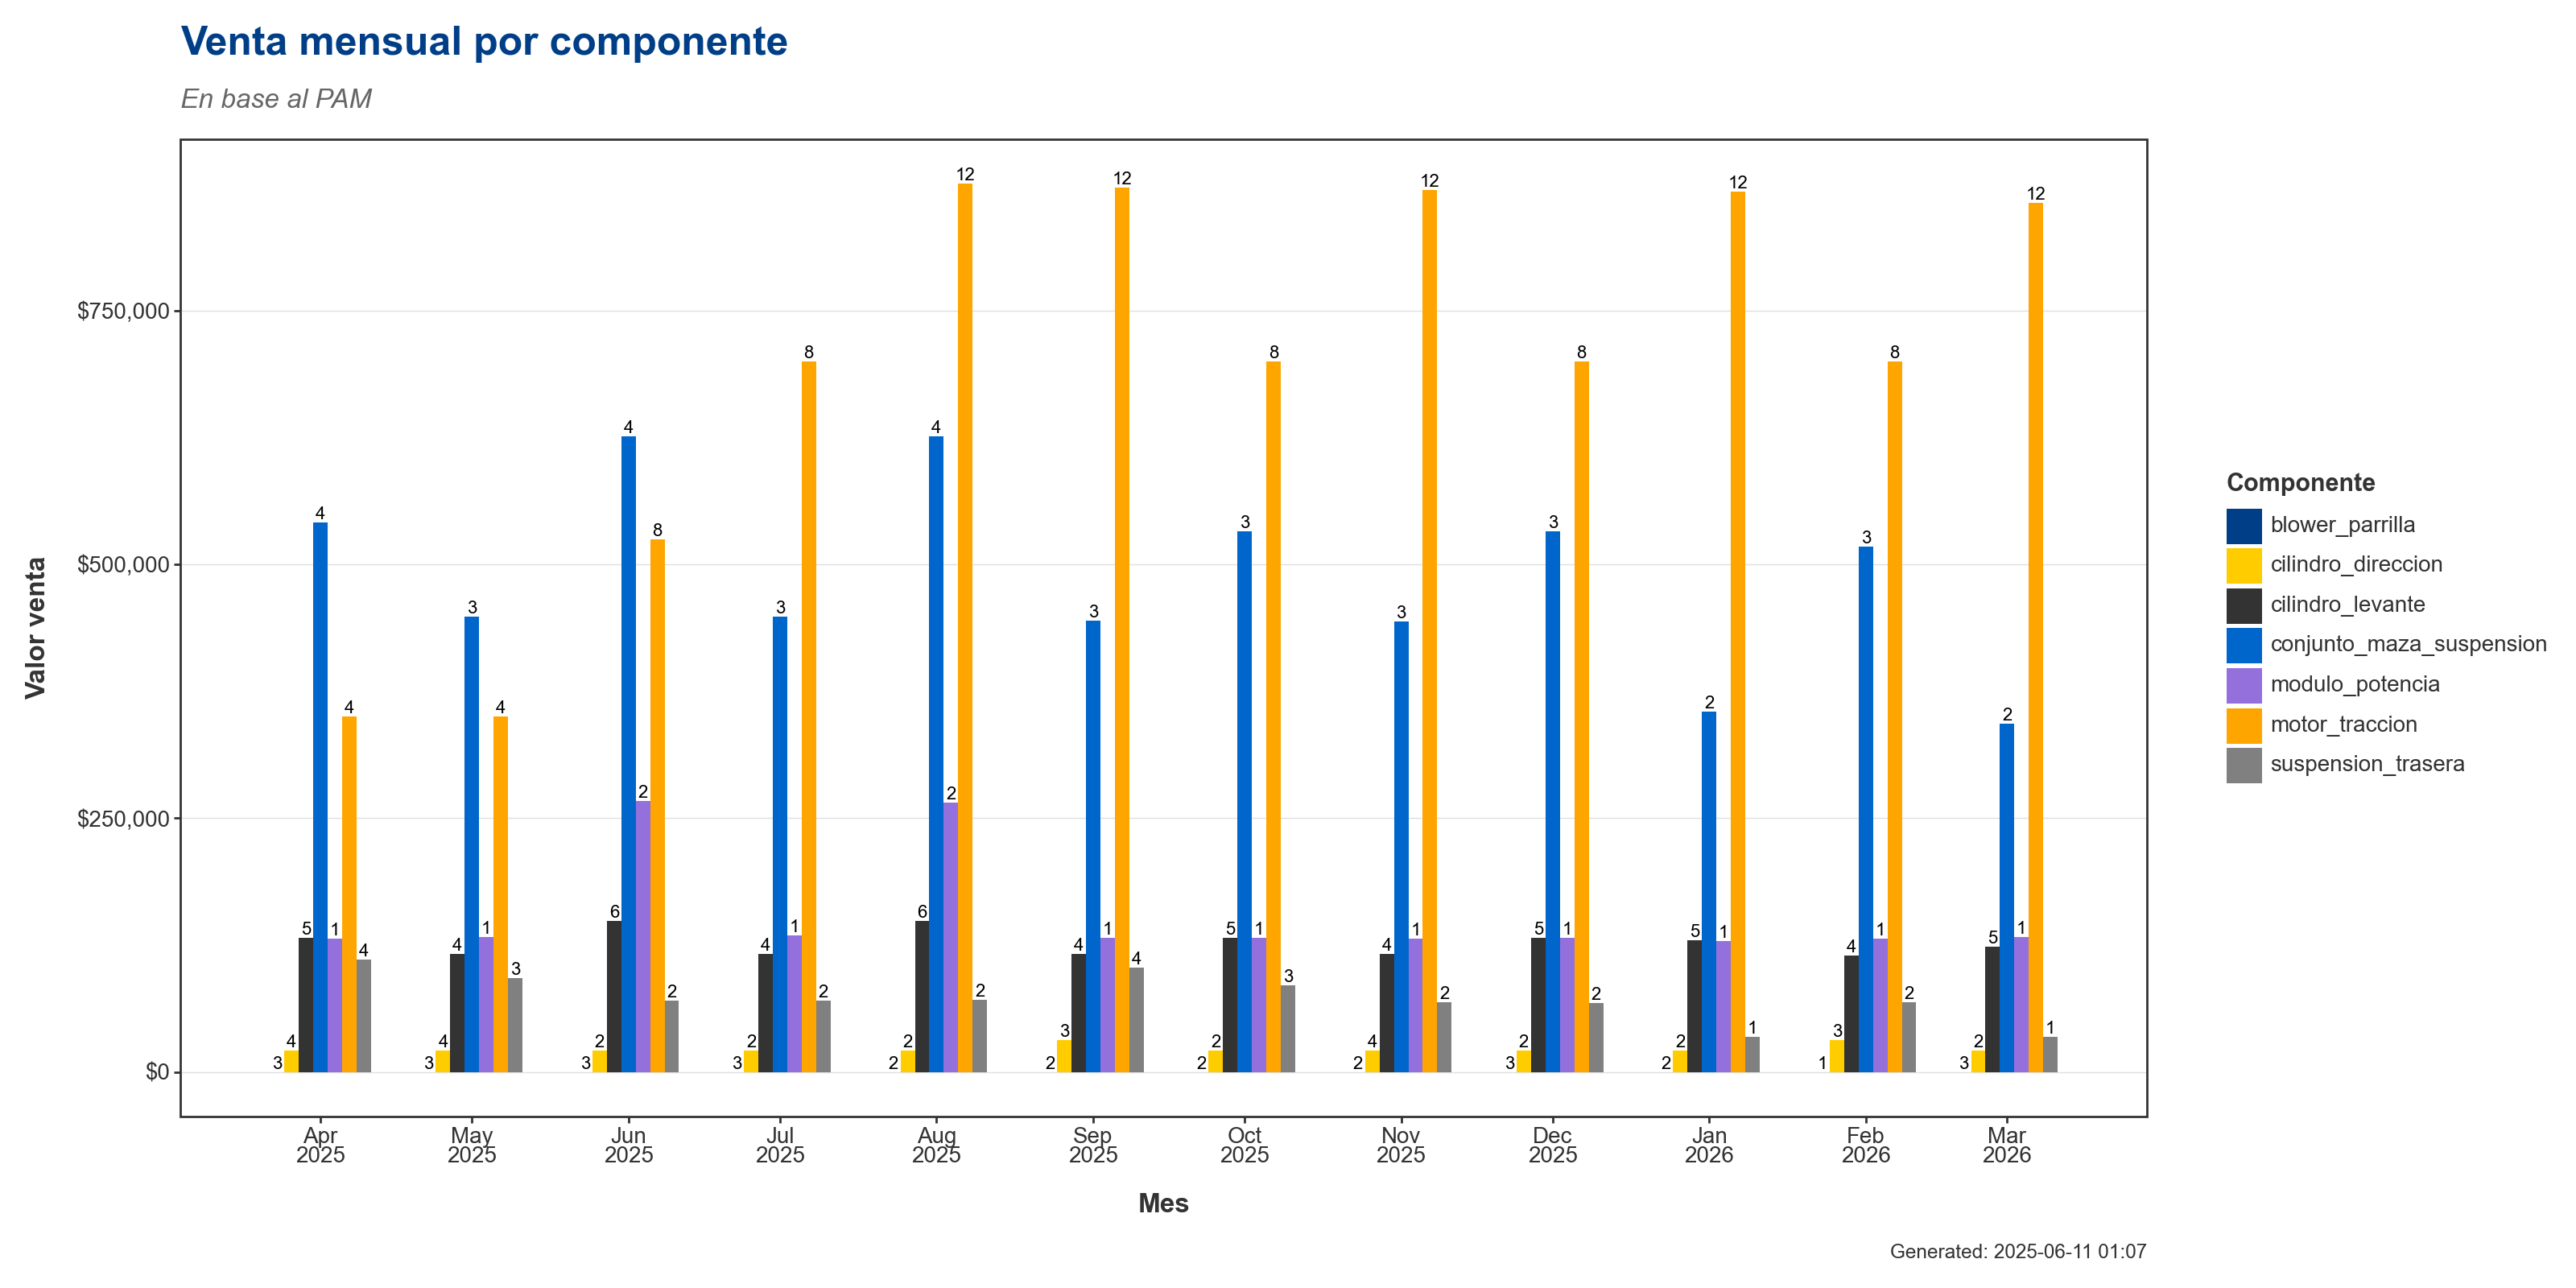

In [184]:
# Step 1: Prepare the data - aggregate by month and component
monthly_component_data = (
    sale_df.with_columns(
        [
            pl.col("proj_changeout_date").dt.year().alias("year"),
            pl.col("proj_changeout_date").dt.month().alias("month"),
            pl.date(
                pl.col("proj_changeout_date").dt.year(),
                pl.col("proj_changeout_date").dt.month(),
                1,
            ).alias("month_date"),
        ]
    )
    .group_by(["month_date", "component_name"])
    .agg(
        [
            pl.col("prorrata_sale").sum().alias("total_prorrata_sale"),
            pl.col("cc_amount").sum().alias("total_changes"),  # Sum of changeouts
        ]
    )
    .sort(["month_date", "component_name"])
)

# Step 2: Create the grouped bar plot
plot = (
    p9.ggplot(
        monthly_component_data.to_pandas(),
        p9.aes(x="month_date", y="total_prorrata_sale", fill="component_name"),
    )
    + p9.geom_col(position="dodge", width=20)  # width in days for datetime
    + p9.geom_text(
        p9.aes(label="total_changes"),
        position=p9.position_dodge(width=20),
        va="bottom",
        size=8,
        format_string="{:.0f}",  # Format as integer
    )
    + p9.scale_fill_manual(values=COMPONENT_COLORS, name="Componente")
    + p9.scale_x_datetime(date_labels="%b\n%Y", date_breaks="1 month")
    + p9.scale_y_continuous(labels=lambda l: [f"${v:,.0f}" for v in l])
    + p9.labs(
        title="Venta mensual por componente",
        subtitle="En base al PAM",
        x="Mes",
        y="Valor venta",
        caption=f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
    )
    + theme_komatsu(figure_size=(16, 8))  # Wider for grouped bars
)
plot